In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
from utils import *
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
# superclass of neural network "modules" (layers)
class Module:
    """
    Module is a super class. It could be a single layer, or a multilayer perceptron.
    """
    
    def __init__(self):
        self.train = True
        return
    
    def forward(self, _input):
        """
        z = f(a); a is the input, and h is the output.
        
        Inputs:
        _input: a
        
        Returns:
        output z
        """
        pass
    
    def backward(self, _input, _gradOutput):
        """
        Compute:
        gradient w.r.t. _input
        gradient w.r.t. trainable parameters
        
        Inputs (in lecture notation):
        _input: a 
        _gradOutput: dL/dz
        
        Returns:
        gradInput: dL/dz
        """
        pass
        
    def parameters(self):
        """
        Return the value of trainable parameters and its corresponding gradient (Used for grandient descent)
        
        Returns:
        params, gradParams
        """
        pass
    
    def training(self):
        """
        Turn the module into training mode.(Only useful for Dropout layer)
        Ignore it if you are not using Dropout.
        """
        self.train = True
        
    def evaluate(self):
        """
        Turn the module into evaluate mode.(Only useful for Dropout layer)
        Ignore it if you are not using Dropout.
        """
        self.train = False
        

In [3]:
# a class representing a sequence of modules (a layered network)
class Sequential(Module):
    """
    Sequential provides a way to plug layers together in a feed-forward manner.
    """
    def __init__(self):
        Module.__init__(self)
        self.layers = [] # layers contain all the layers in order
    
    def add(self, layer):
        self.layers.append(layer) # Add another layer at the end
    
    def size(self):
        return len(self.layers) # How many layers.
    
    def forward(self, _input):
        """
        Feed forward through all the layers, and return the output of the last layer
        """
        # self._inputs saves the input of each layer
        # self._inputs[i] is the input of i-th layer
        self._inputs = [_input]
        for i in range(self.size()):
            # The output of (i-1)-th layer as the _input of i-th layer
            self._inputs.append(self.layers[i].forward(self._inputs[i]))
        # The last element of self._inputs is the output of last layer
        self._output = self._inputs[-1]
        return self._output
    
    def backward(self, _input, _gradOutput):
        """
        Backpropogate through all the layers using chain rule.
        """
        # self._gradInputs[i] is the gradient of loss w.r.t. the input of i-th layer
        self._gradInputs = [None] * (self.size() + 1)
        self._gradInputs[self.size()] = _gradOutput
        for i in reversed(range(self.size())):
            self._gradInputs[i] = \
                self.layers[i].backward(self._inputs[i], self._gradInputs[i + 1])
        self._gradInput = self._gradInputs[0]
        return self._gradInput
    
    def parameters(self):
        """
        Return trainable parameters and its corresponding gradient in a nested list
        """
        params = []
        gradParams = []
        for m in self.layers:
            _p, _g = m.parameters()
            if _p is not None:
                params.append(_p)
                gradParams.append(_g)
        return params, gradParams

    def training(self):
        """
        Turn all the layers into training mode
        """
        Module.training(self)
        for m in self.layers:
            m.training()
    
    def evaluate(self):
        """
        Turn all the layers into evaluate mode
        """
        Module.evaluate(self)
        for m in self.layers:
            m.evaluate()
        

In [21]:
class FullyConnected(Module):
    """
    Fully connected layer (parameters include a matrix of weights a vector of biases)
    """
    def __init__(self, inputSize, outputSize):
        Module.__init__(self)
        # Initalization
        stdv = 2./inputSize
        self.weight = np.random.normal(0, stdv, (inputSize, outputSize))
        self.bias = np.random.normal(0, stdv, outputSize)
        
        # stdv = 1./np.sqrt(inputSize)
        # self.weight = np.random.uniform(-stdv, stdv, (inputSize, outputSize))
        # self.bias = np.random.uniform(-stdv, stdv, outputSize)
        
        self.gradWeight = np.ndarray((inputSize, outputSize))
        self.gradBias = np.ndarray(outputSize)
        
        
    def forward(self, _input):
        """
        output = W * input + b
        """
        self._input = _input
        self._output = self._input.dot(self.weight) + self.bias
        return self._output
    
    def backward(self, _input, _gradOutput):
        """
        gradWeight = gradOutput * input
        gradBias = 
        gradInput =  gradWeight * gradOutput
        """
        self.gradWeight.fill(0)
        self.gradBias.fill(0)
        
        self._gradInput = _gradOutput.dot(self.weight.T)
        self.gradWeight += _input.T.dot(_gradOutput)
        
        self.gradBias += _gradOutput.mean(axis = 0)
        
        
        return self._gradInput
        
    def parameters(self):
        """
        Return weight and bias and their g
        """
        return [self.weight, self.bias], [self.gradWeight, self.gradBias]


In [5]:
class ReLU(Module):
    """
    ReLU activation, not trainable.
    """
    def __init__(self):
        Module.__init__(self)
        return
    
    def forward(self, _input):
        """
        output = max(0, input)
        """
        self._input = _input
        self._output = np.clip(self._input, 0, None)
        return self._output
    
    def backward(self, _input, _gradOutput):
        """
        gradInput = gradOutput * mask
        mask = _input > 0
        """
        self._gradInput = _gradOutput * (self._input > 0)
        return self._gradInput
        
    def parameters(self):
        """
        No trainable parametersm, return None
        """
        return None, None

In [6]:
class Sigmoid(Module):
    """
    sigmoid activation, not trainable.
    HC: this is an element-wise sigmoid. Note the backward gradient
    """
    def __init__(self):
        Module.__init__(self)
        return
    
    def forward(self, _input):
        """
        output = max(0, input)
        """
        self._input = _input
        self._output = 1. /  (1 + np.exp(-self._input))
        return self._output
    
    def backward(self, _input, _gradOutput):
        """
        gradInput = gradOutput * mask
        mask = _input > 0
        """
        self._gradInput = _gradOutput * (1. - self._output) * self._output
        return self._gradInput
        
    def parameters(self):
        """
        No trainable parametersm, return None
        """
        return None, None

In [7]:
# Optional
class Dropout(Module):
    """
    A dropout layer
    """
    def __init__(self, p = 0.5):
        Module.__init__(self)
        self.p = p #self.p is the drop rate, if self.p is 0, then it's a identity layer
        
    def forward(self, _input):
        self._output = _input
        if self.p > 0:
            if self.train:
                # Randomize a mask from bernoulli distrubition
                self.mask = np.random.binomial(1, 1 - self.p, _input.shape).astype('float64')
                # Scale the mask to compensate for the signal weakening. Remember
                self.mask /= 1 - self.p
                self._output *= self.mask
        return self._output
    
    def backward(self, _input, _gradOutput):
        self._gradInput = _gradOutput
        if self.train:
            if self.p > 0:
                self._gradInput *= self.mask
        return self._gradInput
    
    def parameters(self):
        """
        No trainable parameters.
        """
        return None, None

In [8]:
class SoftMaxLoss(object):
    def __init__(self):
        return
        
    def forward(self, _input, _label):
        """
        Softmax and cross entropy loss layer. Should return a scalar, since it's a
        loss. (It's almost identical to what we had in Pset 2)

        Inputs:
        _input: N x C
        _labels: N x C, one-hot

        Returns: loss (scalar)
        """
        self._input = _input - _input.max(1)[:, np.newaxis]
        self._logprob = self._input - np.log(np.exp(self._input).sum(1)[:, np.newaxis])
        
        self._output = np.mean(np.sum(-self._logprob * _label, 1))
        return self._output
    
    def backward(self, _input, _label):
        self._gradInput = -1 * (_label - np.exp(self._logprob)) / _input.shape[0]
        return self._gradInput

In [9]:
# Test softmaxloss, the relative error should be small enough
def test_sm():
    crit = SoftMaxLoss()
    gt = np.zeros((3, 10))
    gt[np.arange(3), np.array([1,2,3])] = 1
    x = np.random.random((3,10))
    def test_f(x):
        return crit.forward(x, gt)

    print(crit.forward(x, gt))

    gradInput = crit.backward(x, gt)
    gradInput_num = numeric_gradient(test_f, x, 1, 1e-6)
    #print(gradInput)
    #print(gradInput_num)
    print(relative_error(gradInput, gradInput_num, 1e-8))
    
test_sm()


2.39717044345
7.27653442711e-09


In [10]:
# Test modules, all the relative errors should be small enough (on the order of 1e-6 or smaller)
def test_module(model):

    model.evaluate()

    crit = TestCriterion()
    gt = np.random.random((3,10))
    x = np.random.random((3,10))
    def test_f(x):
        return crit.forward(model.forward(x), gt)

    gradInput = model.backward(x, crit.backward(model.forward(x), gt))
    gradInput_num = numeric_gradient(test_f, x, 1, 1e-6)
    print(relative_error(gradInput, gradInput_num, 1e-8))

# Test fully connected
model = FullyConnected(10, 10)
print('testing FullyConnected')
test_module(model)

# Test ReLU
model = ReLU()
print('testing ReLU')
test_module(model)

# Test Dropout
#model = Dropout()
#test_module(model)

# Test Sequential
model = Sequential()
model.add(FullyConnected(10, 10))
model.add(ReLU())
model.add(FullyConnected(10, 10))
#model.add(Dropout())
print('testing 2-layer model')
test_module(model)

testing FullyConnected
3.10565369313e-08
testing ReLU
7.36022825478e-10
testing 2-layer model
2.74620328116e-08


In [115]:
# Test gradient descent, the loss should be lower and lower
trainX = np.random.random((10,5))
crit = TestCriterion()
test_learning_rate = 1e-4

In [116]:
model = Sequential()
model.add(FullyConnected(5, 3))
model.add(ReLU())
model.add(Dropout())
model.add(FullyConnected(3, 1))

params, gradParams = model.parameters()

it = 0
state = None
while True:
    output = model.forward(trainX)
    loss = crit.forward(output, None)
    if it % 1000 == 0:
        print(loss)
    doutput = crit.backward(output, None)
    model.backward(trainX, doutput)
    sgdm(params, gradParams, test_learning_rate, 0.8, state)
    if it > 10000:
        break
    it += 1

1.71992048871
1.31619500308
1.31132613878
0.5763378553
0.604524005174
0.471512359734
0.229554708128
0.199302397076
0.249691528335
0.21167737992
0.167189972186


In [117]:
model = Sequential()
model.add(FullyConnected(5, 3))
model.add(ReLU())
model.add(Dropout())
model.add(FullyConnected(3, 1))

params, gradParams = model.parameters()

it = 0
state = None
while True:
    output = model.forward(trainX)
    loss = crit.forward(output, None)
    if it % 1000 == 0:
        print(loss)
    doutput = crit.backward(output, None)
    model.backward(trainX, doutput)
    sgdmom(params, gradParams, test_learning_rate, 0.8, state)
    if it > 10000:
        break
    it += 1

0.469909203261
0.399767970199
0.349676869202
0.307785192283
0.27113201816
0.21855587882
0.22268530393
0.195538427321
0.174265216864
0.133663360399
0.145336644844


In [132]:
# Test gradient descent, the loss should be lower and lower
trainX = np.random.random((10,5))

model = Sequential()
model.add(FullyConnected(5, 3))
model.add(ReLU())
model.add(Dropout())
model.add(FullyConnected(3, 1))

crit = TestCriterion()

params, gradParams = model.parameters()

it = 0
state = None
while True:
    output = model.forward(trainX)
    loss = crit.forward(output, None)
    if it % 1000 == 0:
        print(loss)
    doutput = crit.backward(output, None)
    model.backward(trainX, doutput)
    # sgdm(params, gradParams, 0.01, 0.8, state)
    sgdadam(params, gradParams, lr = test_learning_rate, state = state)
    if it > 10000:
        break
    it += 1
    

0.382865712813
0.00066643146758
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06
2.16156274621e-06


### The above code tests Adam, SGDMomentum, and Nesterov Momentum respectively

Now we start to work on real data. The first one is Fashion MNIST.

In [2]:
import FMNIST_utils

# We only consider large set this time
print("Load large trainset.")
Xlarge,Ylarge = FMNIST_utils.load_data("Tr")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load valset.")
Xval,Yval = FMNIST_utils.load_data("Vl")
print(Xval.shape)
print(Yval.shape)

Load large trainset.
(50000, 784)
(50000, 10)
Load valset.
(10000, 784)
(10000, 10)


In [3]:
Ylarge

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [134]:
def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : a multi-layer perceptron
    Output:
    yhat : N x C array
        yhat[n][:] contains the score over C classes for X[n][:]
    """
    return model.forward(X)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    model.evaluate()
    res = 1 - (model.forward(X).argmax(-1) == Y.argmax(-1)).mean()
    model.training()
    return res

from copy import deepcopy

def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    During training, choose the model with the lowest validation error. (early stopping)
    Assumes (global) variable crit containing the loss (training "criterion" to be minimized)
    """
    
    params, gradParams = model.parameters()
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    # Save the model with lowest validation error
    minValError = np.inf
    saved_model = None # Save the best model accoring to validation error
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        
        s_idx = shuffled_idx[batch_idx]
        
        bX = X[s_idx,:]
        bY = Y[s_idx,:]

        score = model.forward(bX)
        loss = crit.forward(score, bY)
        # note: this computes loss on the *batch* only, not on the entire training set!
        
        dscore = crit.backward(score, bY)
        model.backward(bX, dscore)
        
        # Update the data using preferred update rule
        
        if trainopt['update'] == 'sgdm':
            sgdm(params, gradParams, eta, weight_decay = trainopt['lambda'])    
        elif trainopt['update'] == 'sgd':
            sgd(params, gradParams, eta, weight_decay = trainopt['lambda'])
        elif trainopt['update'] == 'nesterov':
            sgdmom(params, gradParams, eta, weight_decay = trainopt['lambda'])
        elif trainopt['update'] == 'adam':
            sgdadam(params, gradParams, eta, weight_decay = trainopt['lambda'])
        else:
            print("the optimizer {} cannot be identified".format(trainopt['update']))
            break


        start_idx = stop_idx % N
        
        if (iteration % trainopt['display_iter']) == 0:
            #compute train and val error; multiply by 100 for readability (make it percentage points)
            trainError = 100 * error_rate(X, Y, model)
            valError = 100 * error_rate(Xval, Yval, model)
            print('{:8} batch loss: {:.3f} train error: {:.3f} val error: {:.3f}'.format(iteration, loss, trainError, valError))
            
            # early stopping: save the best model snapshot so far (i.e., model with lowest val error)
            if valError < minValError:
                saved_model = deepcopy(model)
                minValError = valError
        
    return saved_model, minValError, trainError

In [135]:
def build_model(input_size, hidden_size, output_size, activation_func = 'ReLU', dropout = 0):
    """
    Build a model:
    input_size: the dimension of input data
    hidden_size: the dimension of hidden vector, hidden_size == 0 means only one layer;
        hidden_size = [h1, h2, ...] specifies multiple layers of sizes h1, h2 etc.
    output_size: the output size of final layer (typically, number of classes).
    activation_func: ReLU, sigmoid (defined above), Tanh (you'd have to define), etc. 
    dropout: the dropout rate: if dropout == 0, this is equivalent to no dropout
    """
    model = Sequential()
    
    if type(hidden_size) is int:
        hidden_size = [hidden_size] # ensure it's a list
    
    prev_size=input_size
    
    # add hidden layer(s) as requested
    if hidden_size[0] == 0: # no hidden layer
        pass
    
    else:
        for l in range(len(hidden_size)):
            model.add(FullyConnected(prev_size, hidden_size[l]))
            prev_size=hidden_size[l]
            
            if activation_func == 'ReLU':
                model.add(ReLU())
            elif activation_func == 'sigmoid':
                model.add(Sigmoid())
                
            if dropout > 0:
                model.add(Dropout(dropout))
                
    # now add output layer  
    model.add(FullyConnected(prev_size, output_size))

        
    return model
    

### Changes made: either system change, or paramter change. 

System Change:
1. Initialization strategy: since I stick to ReLU, switch to Kaiming's N(0, 2/InputSize)
2. Add Adam Optimizer to manage SGD. Learning rate management may now be removed.

Paramter Change:
1. Try different dropout rate.
2. Try size of hidden units

In [28]:
def sgdadam(x, dx, lr, beta1 = 0.9, beta2 = 0.999, state = None, weight_decay = 0):
    # sgd adam optimizer. 
    """ see http://cs231n.github.io/neural-networks-3/
    
    m = beta1*m + (1-beta1)*dx
    v = beta2*v + (1-beta2)*(dx**2)
    x += - learning_rate * m / (np.sqrt(v) + eps)
    """
    if not state:
        if type(x) is list:
            state = [None] * len(x)
        else:
            state = {}
            state['m'] = np.zeros(x.shape)
            state['v'] = np.zeros(x.shape)
    if type(x) is list:
        for _x, _dx, _state in zip(x, dx, state):
            sgdadam(_x, _dx, lr, beta1, beta2, _state, weight_decay)
    else:
        state['m'] = beta1 * state['m'] + (1 - beta1) * dx
        state['v'] = beta2 * state['v'] + (1 - beta2) * (dx ** 2)
        x += - lr * state['m'] / (np.sqrt(state['v']) + 1e-8)

In [136]:
# Common Setup shared by experiments

NFEATURES = Xlarge.shape[1]
# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
trained_models = dict()
trainopt = {
    'eta': 1e-3,   # initial learning rate
    'maxiter': 60000,   # max number of iterations (updates) of SGD
    'display_iter': 5000,  # display batch loss every display_iter updates
    'batch_size': 128,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .25,  # drop eta after every eta_frac*maxiter
    'update': 'sgdm' # SGD with momentum (using the default momentum value, see utils.py)
}
lambda_=0.0001

trainopt['lambda'] = lambda_
crit = SoftMaxLoss()

In [22]:
# do not use lambda as key. Use an experiment id
arch_index = 0 # modifications: Kaiming init strategy. 

hidden_size_=[200,200]
model = build_model(NFEATURES, hidden_size_, 10, dropout = 0)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))


       0 batch loss: 2.307 train error: 89.538 val error: 89.330
    5000 batch loss: 0.339 train error: 14.106 val error: 15.260
   10000 batch loss: 0.274 train error: 11.566 val error: 13.200
   15000 batch loss: 0.381 train error: 9.810 val error: 11.950
   20000 batch loss: 0.380 train error: 9.164 val error: 11.480
   25000 batch loss: 0.273 train error: 9.518 val error: 12.340
   30000 batch loss: 0.246 train error: 8.106 val error: 11.490
   35000 batch loss: 0.174 train error: 7.948 val error: 11.080
   40000 batch loss: 0.234 train error: 7.594 val error: 11.020
   45000 batch loss: 0.205 train error: 7.360 val error: 10.900
   50000 batch loss: 0.151 train error: 6.950 val error: 10.830
   55000 batch loss: 0.172 train error: 6.854 val error: 10.920
train set model [ h = 200 200  ], lambda= 0.0001 ] --> train error: 6.85, val error: 10.83


In [23]:
# do not use lambda as key. Use an experiment id
arch_index = 1 # modifications: Kaiming init strategy. 50% dropout

hidden_size_=[200,200]
model = build_model(NFEATURES, hidden_size_, 10, dropout = 0.5)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.309 train error: 80.028 val error: 80.180
    5000 batch loss: 0.380 train error: 14.734 val error: 15.820
   10000 batch loss: 0.516 train error: 12.674 val error: 13.730
   15000 batch loss: 0.350 train error: 11.340 val error: 12.730
   20000 batch loss: 0.264 train error: 10.492 val error: 12.270
   25000 batch loss: 0.359 train error: 10.064 val error: 12.090
   30000 batch loss: 0.375 train error: 9.868 val error: 12.020
   35000 batch loss: 0.367 train error: 9.544 val error: 11.760
   40000 batch loss: 0.350 train error: 9.196 val error: 11.350
   45000 batch loss: 0.253 train error: 9.016 val error: 11.360
   50000 batch loss: 0.268 train error: 8.968 val error: 11.390
   55000 batch loss: 0.227 train error: 8.858 val error: 11.290
train set model [ h = 200 200  ], lambda= 0.0001 ] --> train error: 8.86, val error: 11.29


#### Notice: dropout alone, as regularization, does not improve the perf. 

In [143]:
# do not use lambda as key. Use an experiment id
arch_index = 3 # modifications: Kaiming init strategy. hidden size [200 200 200] .nestorov momentum

trainopt['update'] = 'nesterov'
trainopt['etadrop'] = 0.5
hidden_size_=[200,200,200]

model = build_model(NFEATURES, hidden_size_, 10, dropout = 0)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.303 train error: 95.282 val error: 95.320
    5000 batch loss: 0.572 train error: 19.354 val error: 19.820
   10000 batch loss: 0.434 train error: 15.220 val error: 16.460
   15000 batch loss: 0.298 train error: 13.158 val error: 14.320
   20000 batch loss: 0.360 train error: 12.680 val error: 13.900
   25000 batch loss: 0.392 train error: 11.922 val error: 13.300
   30000 batch loss: 0.315 train error: 11.408 val error: 12.900
   35000 batch loss: 0.290 train error: 11.340 val error: 13.110
   40000 batch loss: 0.371 train error: 10.722 val error: 12.410
   45000 batch loss: 0.316 train error: 10.784 val error: 12.410
   50000 batch loss: 0.262 train error: 10.384 val error: 12.030
   55000 batch loss: 0.196 train error: 10.304 val error: 12.390
train set model [ h = 200 200 200  ], lambda= 0.0001 ] --> train error: 10.30, val error: 12.03


#### Curiously, going deeper doesn't really help.

In [146]:
# do not use lambda as key. Use an experiment id
arch_index = 4 # modifications: Kaiming init strategy. hidden size [200] nestorov momentum

trainopt['update'] = 'sgdm'
trainopt['etadrop'] = 0.5
hidden_size_=[200]

model = build_model(NFEATURES, hidden_size_, 10, dropout = 0)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.557 train error: 81.876 val error: 81.540
    5000 batch loss: 0.346 train error: 10.242 val error: 12.170
   10000 batch loss: 0.221 train error: 10.024 val error: 13.140
   15000 batch loss: 0.129 train error: 6.504 val error: 10.730
   20000 batch loss: 0.113 train error: 5.760 val error: 10.870
   25000 batch loss: 0.236 train error: 5.074 val error: 10.620
   30000 batch loss: 0.184 train error: 5.042 val error: 11.340
   35000 batch loss: 0.090 train error: 4.262 val error: 10.720
   40000 batch loss: 0.071 train error: 3.332 val error: 10.480
   45000 batch loss: 0.075 train error: 3.100 val error: 10.730
   50000 batch loss: 0.072 train error: 2.682 val error: 10.350
   55000 batch loss: 0.077 train error: 2.734 val error: 10.530
train set model [ h = 200  ], lambda= 0.0001 ] --> train error: 2.73, val error: 10.35


#### A simple 200 hidden layer can be better than [200, 200]. Interesting. 

In [147]:
arch_index = 4 # modifications: Kaiming init strategy. dropout 50%, hidden size [200] nestorov momentum

trainopt['update'] = 'sgdm'
trainopt['etadrop'] = 0.5
hidden_size_=[200]

model = build_model(NFEATURES, hidden_size_, 10, dropout = 0.5)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.880 train error: 76.154 val error: 76.070
    5000 batch loss: 0.370 train error: 10.952 val error: 12.570
   10000 batch loss: 0.348 train error: 9.488 val error: 11.510
   15000 batch loss: 0.189 train error: 8.354 val error: 11.050
   20000 batch loss: 0.291 train error: 7.336 val error: 10.910
   25000 batch loss: 0.358 train error: 6.804 val error: 11.000
   30000 batch loss: 0.298 train error: 6.392 val error: 10.840
   35000 batch loss: 0.322 train error: 5.960 val error: 10.510
   40000 batch loss: 0.264 train error: 5.630 val error: 10.430
   45000 batch loss: 0.231 train error: 5.706 val error: 10.440
   50000 batch loss: 0.181 train error: 5.260 val error: 10.540
   55000 batch loss: 0.186 train error: 5.044 val error: 10.510
train set model [ h = 200  ], lambda= 0.0001 ] --> train error: 5.04, val error: 10.43


#### Dropout alone doesn't seem to help with over-fitting. Need stronger regularization from lambda

In [148]:
arch_index = 5 # modifications: Kaiming init strategy. dropout 50%, hidden size [200] nestorov momentum

trainopt['update'] = 'sgdm'
trainopt['etadrop'] = 0.5
hidden_size_=[400]
model = build_model(NFEATURES, hidden_size_, 10, dropout = 0.5)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.266 train error: 77.602 val error: 77.690
    5000 batch loss: 0.309 train error: 9.638 val error: 11.790
   10000 batch loss: 0.232 train error: 8.954 val error: 12.270
   15000 batch loss: 0.199 train error: 6.128 val error: 10.670
   20000 batch loss: 0.134 train error: 5.036 val error: 10.670
   25000 batch loss: 0.074 train error: 4.800 val error: 10.760
   30000 batch loss: 0.044 train error: 4.264 val error: 10.900
   35000 batch loss: 0.058 train error: 2.904 val error: 10.470
   40000 batch loss: 0.034 train error: 2.764 val error: 10.220
   45000 batch loss: 0.069 train error: 2.318 val error: 10.100
   50000 batch loss: 0.094 train error: 2.292 val error: 10.240
   55000 batch loss: 0.045 train error: 1.522 val error: 10.050
train set model [ h = 400  ], lambda= 0.0001 ] --> train error: 1.52, val error: 10.05


In [149]:
arch_index = 5 # modifications: Kaiming init strategy. dropout 50%, hidden size [200] nestorov momentum

trainopt['update'] = 'sgdm'
trainopt['etadrop'] = 0.5
trainopt['lambda'] = 1e-3
hidden_size_=[400]
model = build_model(NFEATURES, hidden_size_, 10, dropout = 0.5)
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, model, Xval, Yval, trainopt)
trained_models[arch_index] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.585 train error: 81.908 val error: 81.540
    5000 batch loss: 0.400 train error: 10.524 val error: 12.200
   10000 batch loss: 0.347 train error: 8.766 val error: 11.010
   15000 batch loss: 0.212 train error: 7.480 val error: 10.720
   20000 batch loss: 0.305 train error: 6.364 val error: 10.220
   25000 batch loss: 0.206 train error: 6.050 val error: 10.160
   30000 batch loss: 0.203 train error: 5.526 val error: 10.190
   35000 batch loss: 0.212 train error: 4.842 val error: 9.830
   40000 batch loss: 0.196 train error: 4.598 val error: 9.850
   45000 batch loss: 0.148 train error: 4.404 val error: 10.070
   50000 batch loss: 0.187 train error: 4.066 val error: 9.760
   55000 batch loss: 0.187 train error: 3.912 val error: 9.670
train set model [ h = 400  ], lambda= 0.0001 ] --> train error: 3.91, val error: 9.67


In [161]:
# combine test and val data to train a final network for submission based on best setup
# note: since train and val are combined here, val error is irrelevant
# now: [400], dropout 50%, lambda 1e-3, sgdm

Xcomb = np.concatenate((Xlarge, Xval), axis = 0)
Ycomb = np.concatenate((Ylarge, Yval), axis = 0)
trainopt['update'] = 'sgdm'
trainopt['etadrop'] = 0.5
trainopt['lambda'] = 1e-3
hidden_size_=[400]
model = build_model(NFEATURES, hidden_size_, 10, dropout = 0.5)
# -- model trained on large train set
best_trained_model, valErr, trainErr = runTrainVal(Xcomb, Ycomb, model, Xval, Yval, trainopt)

print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 2.806 train error: 66.105 val error: 66.520
    5000 batch loss: 0.318 train error: 10.877 val error: 11.230
   10000 batch loss: 0.298 train error: 9.052 val error: 9.300
   15000 batch loss: 0.406 train error: 8.177 val error: 8.510
   20000 batch loss: 0.227 train error: 6.783 val error: 6.690
   25000 batch loss: 0.225 train error: 6.343 val error: 6.370
   30000 batch loss: 0.227 train error: 5.940 val error: 5.670
   35000 batch loss: 0.213 train error: 5.577 val error: 5.490
   40000 batch loss: 0.113 train error: 5.417 val error: 5.450
   45000 batch loss: 0.146 train error: 4.988 val error: 4.950
   50000 batch loss: 0.163 train error: 4.645 val error: 4.630
   55000 batch loss: 0.253 train error: 4.648 val error: 4.730
train set model [ h = 400  ], lambda= 0.0001 ] --> train error: 4.65, val error: 4.63


#### visualize the learnt features

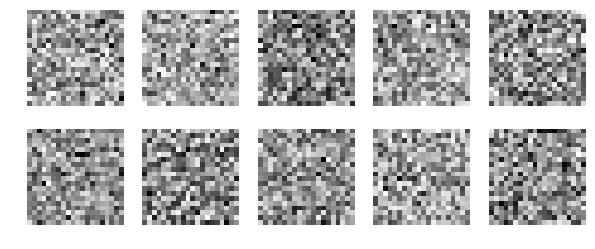

In [182]:
# visualize the 10 features
import matplotlib as mpl
from matplotlib import pyplot

final_features = best_trained_model.parameters()[0][-1][0]

nrows = 2
ncols = 5

plt.figure(figsize=(ncols*2, nrows*2))

for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow( final_features[:,i].reshape(20,20), cmap=mpl.cm.Greys)
    #plt.imshow(2 - pr_v_10[i].reshape((28,28)), cmap=mpl.cm.Greys)
    plt.axis('off')

plt.axis('off')
plt.show()

### These features are human-interpretable (if my code is not wrong) since they have been pre-processed by 

In [162]:
#Generate a Kaggle submission file using best_trained_model which you should set based on your experiments
#best_model_key = max(trained_models.keys(), key = lambda k: trained_models[k]['val_err'])
#best_trained_model = trained_models[best_model_key]['model']
kaggleX = FMNIST_utils.load_data('kaggle')
kaggleYhat = predict(kaggleX, best_trained_model).argmax(-1)
save_submission('submission-mnist.csv', kaggleYhat)

Saved: submission-mnist.csv


### Consumer Reviews

Now let's work on consumer review data (from Pset 3). We will use essentially the same code for the model and training as for Fashion MNIST, but apply it to another data set, with another set of feature functions (mapping text to vectors, instead of mapping images to vectors).

In [218]:
import CR_utils

### Combine uni-gram and bi-gram features.

In [266]:
X_bi, Y_bi, keys_bi = CR_utils.preprocess(use_bigram = True, mincount = 5)
X_uni, Y_uni, keys_uni = CR_utils.preprocess(use_bigram = False,mincount = 8)
X_train = np.hstack((X_bi['train'], X_uni['train']))
Y_train = CR_utils.binarize_labels(np.expand_dims(  Y_uni['train'] , 1))
X_val = np.hstack((X_bi['val'], X_uni['val']))
Y_val = CR_utils.binarize_labels(np.expand_dims(Y_uni['val'],1))
X_test = np.hstack((X_bi['test'], X_uni['test']))

Feature size:  2049
Feature size:  1011


In [259]:

# X, Y, keys = CR_utils.preprocess(use_bigram = False,mincount = 8)
# X_train = X['train']
# Y_train = CR_utils.binarize_labels(np.expand_dims(Y['train'],1))
# X_val = X['val']
# Y_val = CR_utils.binarize_labels(np.expand_dims(Y['val'],1))

In [262]:
# -- training options
trainopt = {
    'eta': 1e-1,   # initial learning rate
    'maxiter': 50000,   # max number of iterations (updates) of SGD
    'display_iter': 3000,  # display batch loss every display_iter updates
    'batch_size': 1,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .25,  # how ofter to drop eta
    'update': 'sgdm'
}

NFEATURES = X_train.shape[1]

lambda_= 1.
hidden_size_=[80, 50]

trainopt['lambda'] = lambda_
model = build_model(NFEATURES, hidden_size_, 2, dropout = 0.5)
crit = SoftMaxLoss()
# -- model trained on large train set
trained_model,valErr,trainErr = runTrainVal(X_train, Y_train, model, X_val, Y_val, trainopt)
trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
print('train set model [ h = ',end='')
for l in range(len(hidden_size_)):
    print('%d '%hidden_size_[l],end='')
print(' ], lambda= %.4f ] --> train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

       0 batch loss: 0.677 train error: 36.360 val error: 33.000
    3000 batch loss: 1.055 train error: 29.982 val error: 30.400
    6000 batch loss: 0.528 train error: 27.207 val error: 30.800
    9000 batch loss: 0.422 train error: 23.099 val error: 33.200
   12000 batch loss: 1.039 train error: 17.369 val error: 30.400
   15000 batch loss: 0.000 train error: 11.423 val error: 28.400
   18000 batch loss: 0.849 train error: 10.342 val error: 27.600
   21000 batch loss: 0.020 train error: 9.586 val error: 26.400
   24000 batch loss: 0.014 train error: 9.658 val error: 26.400
   27000 batch loss: 0.140 train error: 6.270 val error: 27.800
   30000 batch loss: 0.005 train error: 5.586 val error: 27.600
   33000 batch loss: 0.006 train error: 3.712 val error: 27.200
   36000 batch loss: 0.000 train error: 2.739 val error: 27.600
   39000 batch loss: 0.000 train error: 1.946 val error: 27.400
   42000 batch loss: 0.249 train error: 1.333 val error: 28.000
   45000 batch loss: 0.028 train 

In [264]:
# combine the train and val data; note val acc is irrelavant here
Xcomb = np.concatenate((X_train, X_val), axis = 0)
Ycomb = np.concatenate((Y_train, Y_val), axis = 0)
model = build_model(NFEATURES, hidden_size_, 2, dropout = 0.5)
best_trained_model, valErr, trainErr = runTrainVal(Xcomb, Ycomb, model, X_val, Y_val, trainopt)

       0 batch loss: 0.699 train error: 64.153 val error: 67.000
    3000 batch loss: 1.500 train error: 32.153 val error: 30.000
    6000 batch loss: 1.264 train error: 21.771 val error: 24.800
    9000 batch loss: 0.460 train error: 29.740 val error: 31.400
   12000 batch loss: 1.361 train error: 21.832 val error: 22.200
   15000 batch loss: 0.484 train error: 14.412 val error: 17.600
   18000 batch loss: 0.174 train error: 13.710 val error: 15.200
   21000 batch loss: 0.090 train error: 11.176 val error: 13.000
   24000 batch loss: 0.970 train error: 11.481 val error: 13.200
   27000 batch loss: 0.463 train error: 8.580 val error: 12.000
   30000 batch loss: 1.390 train error: 8.672 val error: 11.600
   33000 batch loss: 0.000 train error: 6.198 val error: 7.400
   36000 batch loss: 0.602 train error: 5.649 val error: 8.400
   39000 batch loss: 0.004 train error: 4.244 val error: 5.200
   42000 batch loss: 0.073 train error: 3.664 val error: 4.600
   45000 batch loss: 0.002 train er

In [268]:
# best_model_key = max(trained_models.keys(), key = lambda k: trained_models[k]['val_err'])
# best_trained_model = trained_models[best_model_key]['model']
y_hat = predict(X_test, best_trained_model).argmax(-1) * 2 - 1
CR_utils.save_submission('submission-CR.csv', y_hat)

In [4]:
results = np.zeros((3,3))

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [ ]:
for i in 